<a href="https://colab.research.google.com/github/jdbrinegar/jdbrinegar/blob/main/TF_example_IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Copyright 2019 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

In [2]:
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.15.0
Eager mode:  True
Hub version:  0.16.1
GPU is NOT AVAILABLE


In [3]:
train_data, test_data = tfds.load(name="imdb_reviews", split=["train", "test"],
                                  batch_size=-1, as_supervised=True)

train_examples, train_labels = tfds.as_numpy(train_data)
test_examples, test_labels = tfds.as_numpy(test_data)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteNFH1JU/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteNFH1JU/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteNFH1JU/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [4]:
print("Training entries: {}, test entries: {}".format(len(train_examples), len(test_examples)))

Training entries: 25000, test entries: 25000


In [5]:
train_examples[:10]

array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot 

In [6]:
train_labels[:10]

array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0])

In [7]:
model = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)
hub_layer(train_examples[:3])

<tf.Tensor: shape=(3, 50), dtype=float32, numpy=
array([[ 0.5423195 , -0.0119017 ,  0.06337538,  0.06862972, -0.16776837,
        -0.10581174,  0.16865303, -0.04998824, -0.31148055,  0.07910346,
         0.15442263,  0.01488662,  0.03930153,  0.19772711, -0.12215476,
        -0.04120981, -0.2704109 , -0.21922152,  0.26517662, -0.80739075,
         0.25833532, -0.3100421 ,  0.28683215,  0.1943387 , -0.29036492,
         0.03862849, -0.7844411 , -0.0479324 ,  0.4110299 , -0.36388892,
        -0.58034706,  0.30269456,  0.3630897 , -0.15227164, -0.44391504,
         0.19462997,  0.19528408,  0.05666234,  0.2890704 , -0.28468323,
        -0.00531206,  0.0571938 , -0.3201318 , -0.04418665, -0.08550783,
        -0.55847436, -0.23336391, -0.20782952, -0.03543064, -0.17533456],
       [ 0.56338924, -0.12339553, -0.10862679,  0.7753425 , -0.07667089,
        -0.15752277,  0.01872335, -0.08169781, -0.3521876 ,  0.4637341 ,
        -0.08492756,  0.07166859, -0.00670817,  0.12686075, -0.19326553,
 

In [8]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dense (Dense)               (None, 16)                816       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 48191433 (183.84 MB)
Trainable params: 48191433 (183.84 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])

In [10]:
x_val = train_examples[:10000]
partial_x_train = train_examples[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

In [12]:
results = model.evaluate(test_examples, test_labels)

print(results)

782/782 [==============================] - 3s 4ms/step - loss: 0.6919 - accuracy: 0.5189
[0.6919422745704651, 0.5189200043678284]


In [14]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 45s 1s/step - loss: 0.6455 - accuracy: 0.6649 - val_loss: 0.5955 - val_accuracy: 0.7359
Epoch 2/40
30/30 [==============================] - 44s 1s/step - loss: 0.5282 - accuracy: 0.7868 - val_loss: 0.4881 - val_accuracy: 0.7960
Epoch 3/40
30/30 [==============================] - 43s 1s/step - loss: 0.3981 - accuracy: 0.8493 - val_loss: 0.3959 - val_accuracy: 0.8360
Epoch 4/40
30/30 [==============================] - 44s 1s/step - loss: 0.2934 - accuracy: 0.8972 - val_loss: 0.3454 - val_accuracy: 0.8560
Epoch 5/40
30/30 [==============================] - 45s 1s/step - loss: 0.2179 - accuracy: 0.9285 - val_loss: 0.3193 - val_accuracy: 0.8662
Epoch 6/40
30/30 [==============================] - 44s 1s/step - loss: 0.1615 - accuracy: 0.9515 - val_loss: 0.3068 - val_accuracy: 0.8718
Epoch 7/40
30/30 [==============================] - 43s 1s/step - loss: 0.1185 - accuracy: 0.9715 - val_loss: 0.3049 - val_accuracy: 0.8741
Epoch 8/40
30/30 [==

In [15]:
results = model.evaluate(test_examples, test_labels)

print(results)

782/782 [==============================] - 138s 176ms/step - loss: 0.6088 - accuracy: 0.8444
[0.6087710857391357, 0.8444399833679199]


In [16]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

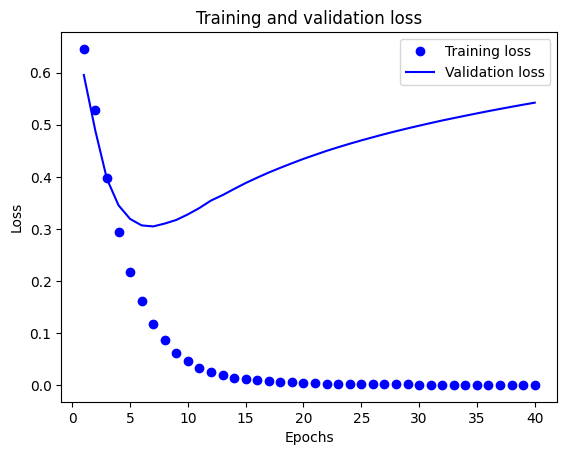

In [17]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

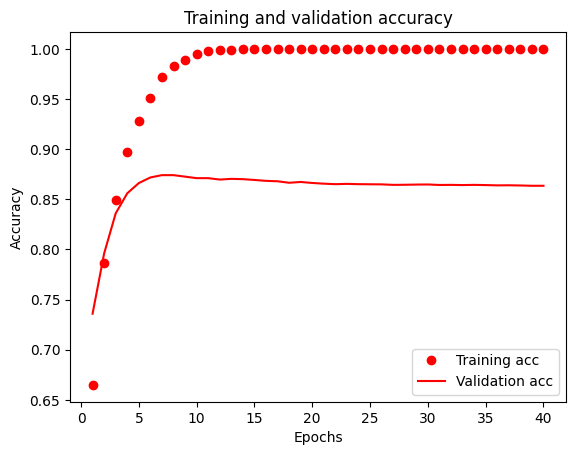

In [20]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()